In [70]:
# Ensure Mac ARM chip is used as GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [71]:
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a * b
    print(c)

tf.Tensor([ 4. 10. 18.], shape=(3,), dtype=float32)


## This notebook focuses on different ways to embed text as vectors using the Keras library

In essence, the Embedding layer is like a dictionary that maps integer indices to dense vectors:

Word index -> Embedding layer -> Corresponding word vector

In [72]:
from keras.layers import Embedding
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import os

In [73]:
# Loading the data
# Only loads the 10,000 most common words
max_features = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [74]:
model = Sequential()

# 10000 - the number of possible tokens
# 8 - the dimensionality of the encodings
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_8 (Flatten)         (None, 160)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 161       
                                                                 
Total params: 80161 (313.13 KB)
Trainable params: 80161 (313.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 0.6554 - acc: 0.6498 - val_loss: 0.5905 - val_acc: 0.7070
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5192 - acc: 0.7581 - val_loss: 0.5123 - val_acc: 0.7410
Epoch 3/10
625/6

The model above exhibits certain shortcomings. The biggest one is that it is unable to identify semantic connection and structure of words within a sentence. This leads to misinterpretations of natural language (i.e. "this movie is THE bomb" == "this movie is a bomb"). We will attempt better approaches using a 1-D convolutional neural network (CNN) and a recurrent neural network (RNN)

In [75]:
# Load raw text data
# -> Processing the labels of the raw IMDB data
imdb_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [76]:
# Tokenizing the text of the raw IMDB data
maxlen = 100 # cut off reviews after 100 words
training_samples = 200
validation_samples = 10000
max_words = 10000 # considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)

In [77]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [78]:
# Use precomputed embeddings from Stanford GloVe

glove_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [79]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [80]:
# Create a simple NN
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=[x_val, y_val])
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 2s 21ms/step - loss: 1.3895 - acc: 0.5395 - val_loss: 0.7804 - val_acc: 0.5550
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 0.7415 - acc: 0.5900 - val_loss: 0.7351 - val_acc: 0.5817
Epoch 3/10
63/63 [==============================] - 1s 14ms/step - loss: 0.6440 - acc: 0.6535 - val_loss: 0.7334 - val_acc: 0.5868
Epoch 4/10
63/63 [==============================] - 1s 15ms/step - loss: 0.5344 - acc: 0.7380 - val_loss: 0.6947 - val_acc: 0.6178
Epoch 5/10
63/63 [==============================] - 1s 15ms/step - loss: 0.5193 - acc: 0.7500 - val_loss: 0.6947 - val_acc: 0.6235
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 0.4334 - acc: 0.8080 - val_loss: 0.6975 - val_acc: 0.6304
Epoch 7/10
63/63 [==============================] - 1s 15ms/step - loss: 0.3820 - acc: 0.8275 - val_loss: 0.7137 - val_acc: 0.6359
Epoch 8/10
63/63 [==============================] - 1s 15ms/step - loss: 0.3291 - a

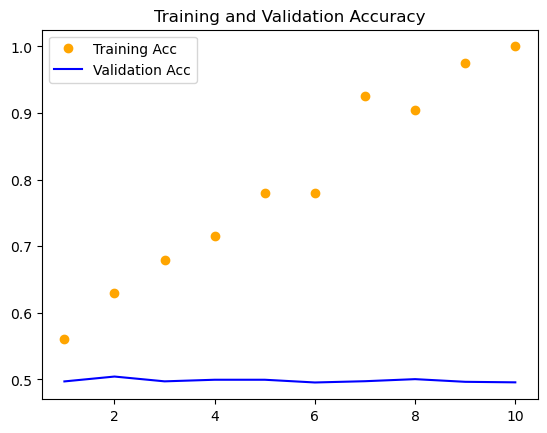

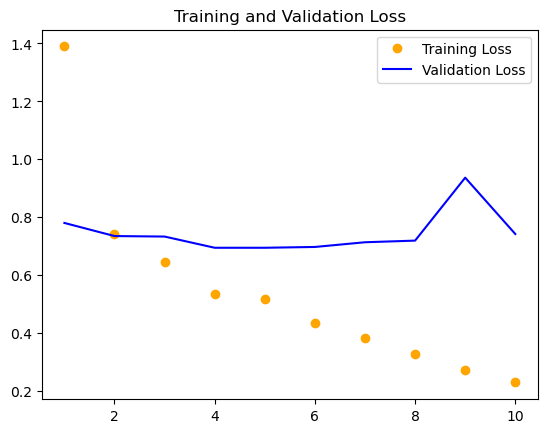

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', color='orange', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [82]:
# Load test data
imdb_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/aclImdb'

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences=tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [83]:
# Evaluate on test data
model.load_weights('pre_trained_glove_model.h5')
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 2s 3ms/step - loss: 0.6965 - acc: 0.6733
Loss: 0.6965315341949463
Accuracy: 0.6732800006866455


## Conclusions

Overall, the approach was ineffective at categorizing the training examples as positive or negative based on the words & text. It performed better with local embeddings achieving a validation accuracy score of ~75%, however, with pre-weighted embeddings from GloVe it did worse at around ~67% testing accuracy. 

This can likely be attributed to the fact that the second model was trained on a small number of examples and the dense layer is not the best approach to classifying natural language. In future notebooks, I will try out different approaches including 1D CNN and RNN to see how theyc an